# **DistilBERT Model**

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
data = pd.read_csv('FullDataset.csv', encoding = "Latin-1")

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Separating features and labels
X = data['Head_Notes']
y = data.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define hyperparameters
MAX_LENGTH = 512
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

In [ ]:
class LegalJudgementsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Tokenize and encode the datasets
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

In [ ]:
# Extract labels from the datasets
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
train_dataset = LegalJudgementsDataset(train_encodings, train_labels)
test_dataset = LegalJudgementsDataset(test_encodings, test_labels)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Define the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)
model.train()

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def compute_accuracy(preds, labels):
    preds = torch.sigmoid(preds).round()
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc

In [ ]:
train_losses = []
train_accuracies = []

EPOCHS = 7
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    total_train_acc = 0
    for batch in tqdm(train_loader, desc="Epoch " + str(epoch + 1)):
        optimizer.zero_grad()
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += compute_accuracy(outputs.logits, labels).item()

    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Training Loss: {average_train_loss}')
    average_train_acc = total_train_acc / len(train_loader)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Training Accuracy: {average_train_acc}')

    train_losses.append(average_train_loss)
    train_accuracies.append(average_train_acc)

Epoch 1: 100%|██████████| 22/22 [07:35<00:00, 20.69s/it]


Epoch 1/7, Average Training Loss: 0.5920879136432301
Epoch 1/7, Average Training Accuracy: 0.7395833324302327


Epoch 2: 100%|██████████| 22/22 [06:06<00:00, 16.67s/it]


Epoch 2/7, Average Training Loss: 0.49211434613574634
Epoch 2/7, Average Training Accuracy: 0.8001893948424946


Epoch 3: 100%|██████████| 22/22 [06:12<00:00, 16.92s/it]


Epoch 3/7, Average Training Loss: 0.4392038041895086
Epoch 3/7, Average Training Accuracy: 0.8399621221152219


Epoch 4: 100%|██████████| 22/22 [06:13<00:00, 16.98s/it]


Epoch 4/7, Average Training Loss: 0.3733588321642442
Epoch 4/7, Average Training Accuracy: 0.8778409090909091


Epoch 5: 100%|██████████| 22/22 [06:01<00:00, 16.45s/it]


Epoch 5/7, Average Training Loss: 0.30652366510846396
Epoch 5/7, Average Training Accuracy: 0.9071969633752649


Epoch 6: 100%|██████████| 22/22 [05:41<00:00, 15.53s/it]


Epoch 6/7, Average Training Loss: 0.24607665565880862
Epoch 6/7, Average Training Accuracy: 0.935606065121564


Epoch 7: 100%|██████████| 22/22 [05:41<00:00, 15.51s/it]

Epoch 7/7, Average Training Loss: 0.20141704312779687
Epoch 7/7, Average Training Accuracy: 0.967803031206131


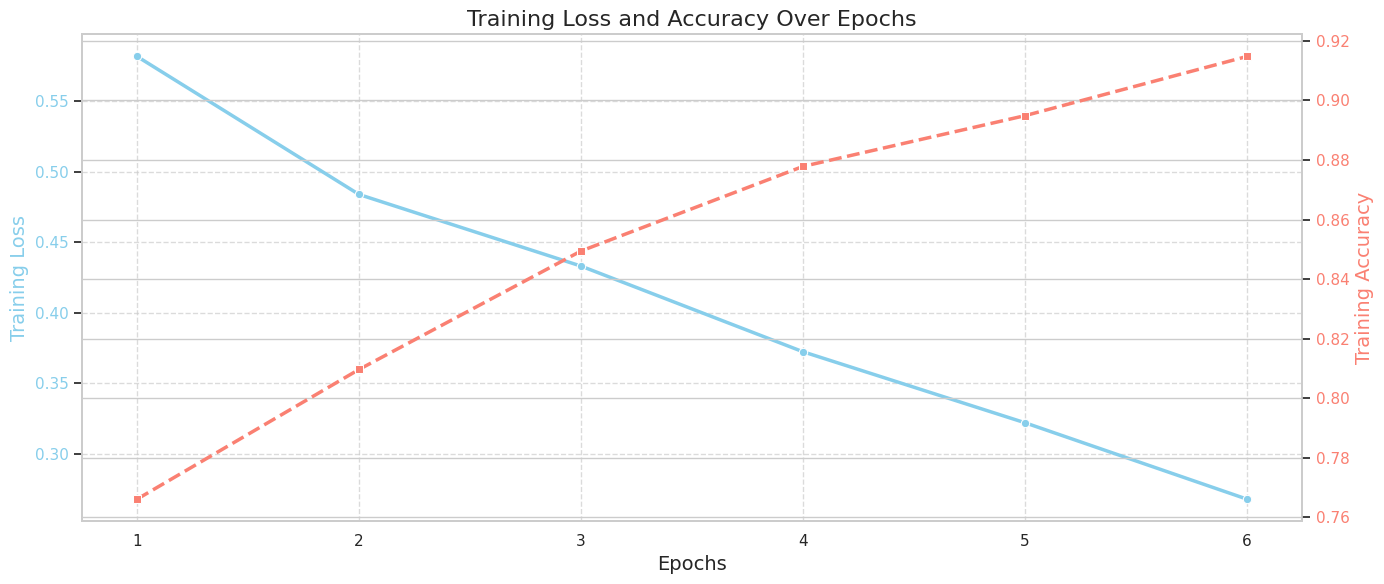

In [ ]:
# Create a DataFrame for better visualization with Seaborn
graph = pd.DataFrame({
    'Epoch': range(1, EPOCHS + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies
})

# Set the Seaborn style
sns.set(style="whitegrid")

# Plot Training Loss and Accuracy in a single graph
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Training Loss
sns.lineplot(x='Epoch', y='Training Loss', data=graph, marker='o', color='skyblue', linewidth=2.5, ax=ax1)
ax1.set_title('Training Loss and Accuracy Over Epochs', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Training Loss', fontsize=14, color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(range(1, EPOCHS + 1))

# Create a second y-axis to plot Training Accuracy
ax2 = ax1.twinx()
sns.lineplot(x='Epoch', y='Training Accuracy', data=graph, marker='s', color='salmon', linewidth=2.5, linestyle='--', ax=ax2)
ax2.set_ylabel('Training Accuracy', fontsize=14, color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
num_batches = 0
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation"):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs.logits)

        # Thresholding predictions
        binary_predictions = (predictions > 0.4).int()

        # Calculate accuracy
        batch_accuracy = (binary_predictions == labels).float().mean().item()
        batch_precision = precision_score(labels.cpu(), binary_predictions.cpu(), average='micro')
        batch_recall = recall_score(labels.cpu(), binary_predictions.cpu(), average='micro')
        batch_f1 = f1_score(labels.cpu(), binary_predictions.cpu(), average='micro')

        total_accuracy += batch_accuracy
        total_precision += batch_precision
        total_recall += batch_recall
        total_f1 += batch_f1
        num_batches += 1

        # Append predicted labels for this batch
        predicted_labels.extend(binary_predictions.tolist())

# Calculate average metrics
average_accuracy = total_accuracy / num_batches
average_precision = total_precision / num_batches
average_recall = total_recall / num_batches
average_f1 = total_f1 / num_batches

print("Accuracy:", average_accuracy)
print("Precision:", average_precision)
print("Recall:", average_recall)
print("F1 Score:", average_f1)

Evaluation: 100%|██████████| 6/6 [00:21<00:00,  3.56s/it]

Accuracy: 0.9861111144224802
Precision: 0.9542929292929293
Recall: 0.9848484848484849
F1 Score: 0.9688301782123293


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels.cpu().numpy().flatten(), binary_predictions.cpu().numpy().flatten())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False, annot_kws={"fontsize": 12})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Convert the predicted labels list to a tensor
predicted_labels_tensor = torch.tensor(predicted_labels)

# Assuming your labels are in a list of lists format, convert to tensor
actual_labels_tensor = torch.tensor(test_dataset.labels)

# Show the predicted labels for every instance
for idx, (predicted_label, actual_label) in enumerate(zip(predicted_labels_tensor, actual_labels_tensor)):
    print(f"Instance {idx}:")
    print("Predicted Label:", predicted_label)
    print("Actual Label:", actual_label)

# **SVM Classifier**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# df = pd.read_csv('FullDataset.csv', encoding = "Latin-1")
df = pd.read_csv('DatasetMix.csv', encoding = "Latin-1")

# Split the dataset into features and labels
X = df['Head_Notes']
y = df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Define the TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# # Define the SVM classifier
# svm_classifier = SVC(kernel='linear', probability=True)

# # Create a pipeline with TF-IDF vectorizer and SVM classifier
# pipeline = Pipeline([
#     ('tfidf', tfidf_vectorizer),
#     ('clf', MultiOutputClassifier(svm_classifier))
# ])

In [ ]:
# Initialize lists to hold evaluation metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

In [ ]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)

# Create a multi-output classifier
multi_output_svm = MultiOutputClassifier(svm_classifier)

# Fit the classifier on the transformed training data
multi_output_svm.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=SVC(kernel='linear', probability=True))

In [ ]:
import numpy as np
# Predict probabilities for the test set
y_test_pred_proba = multi_output_svm.predict_proba(X_test_tfidf)

# Define threshold for classification
threshold = 0.55

# Convert list of arrays to a 2D numpy array
y_test_pred = np.array([probas[:, 1] if probas.ndim > 1 else probas for probas in y_test_pred_proba]).T

# Apply threshold to get binary predictions
y_test_pred = (y_test_pred >= threshold).astype(int)

In [ ]:
# Compute metrics for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')
test_f1_score = f1_score(y_test, y_test_pred, average='micro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

Test Accuracy: 0.8125
Test Precision: 0.9090909090909091
Test Recall: 0.9302325581395349
Test F1 Score: 0.9195402298850575


In [ ]:
# Print actual and predicted labels for each instance
for i in range(len(X_test)):
    print("Instance:", X_test.iloc[i])
    print("Actual labels:", y_test.iloc[i].values)
    print("Predicted labels:", y_test_pred[i])
    print()

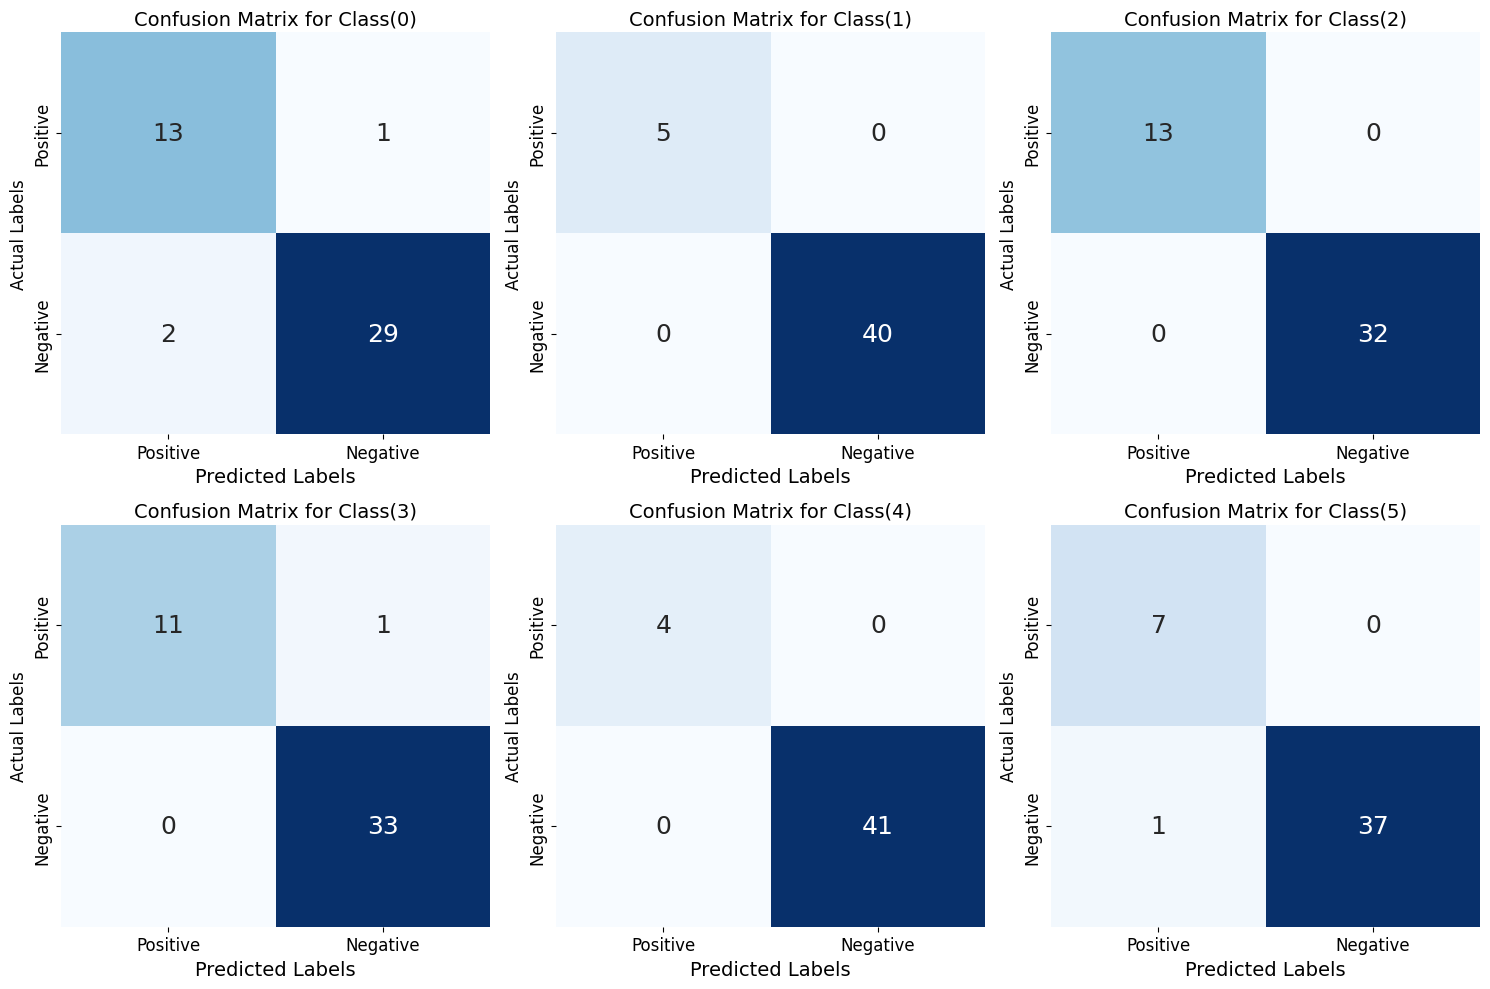

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Compute the confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_test, y_test_pred)

# Plot all confusion matrices in one frame
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    # Get the confusion matrix
    cm = confusion_matrices[i]
    # Manually rearrange the values
    rearranged_cm = [[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]]
    sns.heatmap(rearranged_cm, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 18}, cbar=False)
    ax.set_title(f'Confusion Matrix for Class({i})', fontsize=14)
    ax.set_xticklabels(['Positive', 'Negative'], fontsize=12)
    ax.set_yticklabels(['Positive', 'Negative'], fontsize=12)
    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('Actual Labels', fontsize=12)
plt.tight_layout()
plt.show()


# **LSTM Model**

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# data = pd.read_csv('FullDataset.csv', encoding = "Latin-1")
data = pd.read_csv('DatasetMix.csv', encoding = "Latin-1")

In [ ]:
# Separating features and labels
X = data['Head_Notes']
y = data.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-4-8f1d5a920a4a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_d")  # Using a different color palette


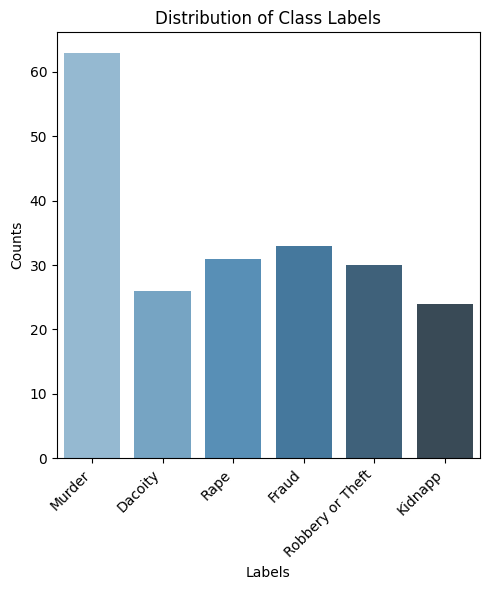

In [ ]:
# Calculate the number of occurrences of each class label
label_counts = y.sum(axis=0)

# Plotting the distribution of class labels
plt.figure(figsize=(5, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_d")  # Using a different color palette
plt.title('Distribution of Class Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

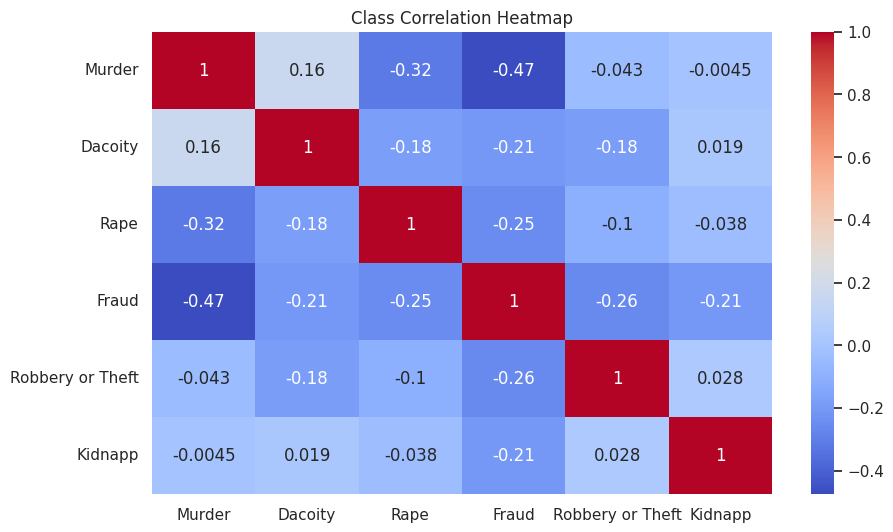

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(y.corr(), annot=True, cmap='coolwarm')
plt.title('Class Correlation Heatmap')
plt.show()

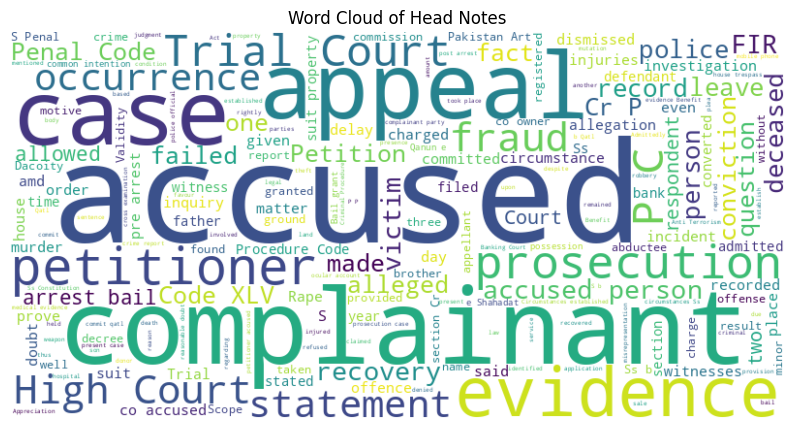

In [ ]:
from wordcloud import WordCloud

text = " ".join(review for review in data['Head_Notes'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Head Notes')
plt.show()

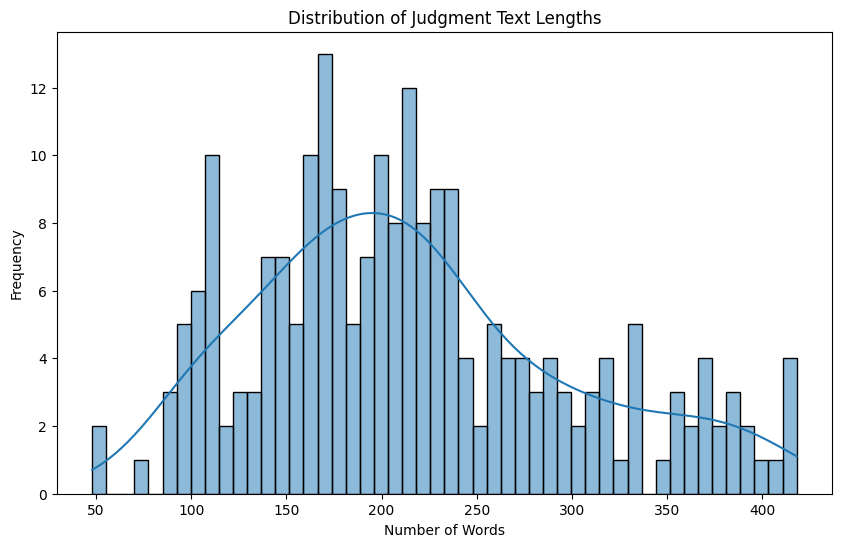

In [ ]:
## Text Length Distribution
text_lengths = X.apply(lambda x: len(x.split()))  # Calculate the length of each text
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Distribution of Judgment Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Tokenize and encode the datasets
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(X_train).toarray()  # Convert to dense format
X_test = vectorizer.transform(X_test).toarray()  # Convert to dense format

y_train = y_train.values
y_test = y_test.values

In [ ]:
# Define hyperparameters
MAX_LENGTH = 512
BATCH_SIZE = 8
LEARNING_RATE = 0.001

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # * 2 for bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Extract the last hidden state output
        last_hidden_state = lstm_out[:, -1, :]
        out = self.fc(last_hidden_state)
        return out

In [ ]:
# Prepare data loaders
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 6  # Number of labels
model = LSTMClassifier(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
EPOCHS = 4
train_losses = []
train_accuracies = []
val_losses = []
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()

        # Reshape inputs to (batch_size, sequence_length, input_dim)
        inputs = inputs.unsqueeze(1)  # Add sequence_length dimension
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct_predictions += (predictions == labels).float().sum()
        total_predictions += labels.numel()

    # Calculate average training loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    training_accuracy = correct_predictions / total_predictions

    # Append the values to the lists
    train_losses.append(average_loss)
    train_accuracies.append(training_accuracy.item())

    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Training Loss: {average_loss}, Training Accuracy: {training_accuracy}')

Epoch 1: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


Epoch 1/4, Average Training Loss: 0.61988765001297, Training Accuracy: 0.7069892287254333


Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 2/4, Average Training Loss: 0.41545943915843964, Training Accuracy: 0.8413978219032288


Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 3/4, Average Training Loss: 0.2632303675636649, Training Accuracy: 0.9206989407539368


Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]

Epoch 4/4, Average Training Loss: 0.143975923769176, Training Accuracy: 0.9946236610412598


In [ ]:
import seaborn as sns

# Set the style and palette for seaborn
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(6, 6))

# Plot Training Loss
sns.lineplot(x=range(1, EPOCHS + 1), y=train_losses, marker='o', color='grey', linestyle='-', label='Training Loss')

# Plot Training Accuracy
sns.lineplot(x=range(1, EPOCHS + 1), y=train_accuracies, marker='s', color='salmon', linestyle='--', label='Training Accuracy')

# Add titles and labels
plt.title('Training Loss and Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Show gridlines with custom style
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the ticks on the x-axis to be integers
plt.xticks(range(1, EPOCHS + 1), fontsize=12)
plt.yticks(fontsize=12)

# Show the legend
plt.legend(fontsize=12)

# Adjust layout to fit everything
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Testing phase
model.eval()
total_test_loss = 0
correct_test_predictions = 0
total_test_predictions = 0

all_predictions = []
all_labels = []

test_losses = []  # List to store test losses for each batch

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add sequence_length dimension
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        test_losses.append(loss.item())  # Store test loss for this batch

        # Calculate testing accuracy
        predictions = (torch.sigmoid(outputs) >= 0.43).float()
        correct_test_predictions += (predictions == labels).float().sum()
        total_test_predictions += labels.numel()

        all_predictions.append(predictions)
        all_labels.append(labels)

# Calculate average test loss and testing accuracy
average_test_loss = total_test_loss / len(test_loader)
testing_accuracy = correct_test_predictions / total_test_predictions

print(f'Test Loss: {average_test_loss}, Test Accuracy: {testing_accuracy}')


Test Loss: 0.16925259679555893, Test Accuracy: 0.96875


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Concatenate all predictions and labels
all_predictions = torch.cat(all_predictions).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# Compute precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='micro')

print("Micro-averaged Precision:", precision)
print("Micro-averaged Recall:", recall)
print("Micro-averaged F1-score:", f1)

Micro-averaged Precision: 0.9743589743589743
Micro-averaged Recall: 0.8837209302325582
Micro-averaged F1-score: 0.9268292682926831


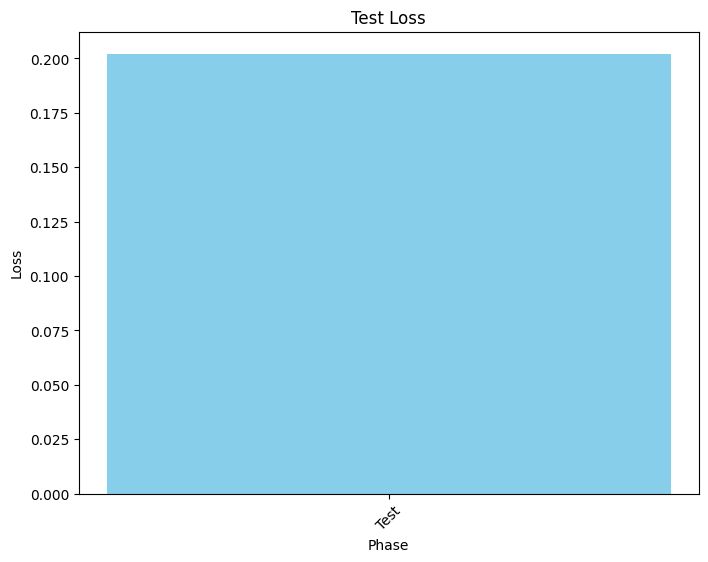

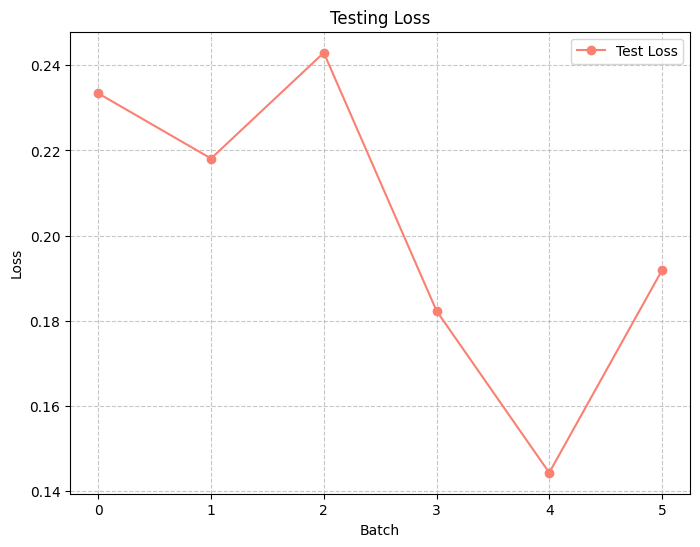

In [ ]:
# Plot Test Loss
plt.figure(figsize=(8, 6))
plt.bar("Test", average_test_loss, color='skyblue')
plt.title('Test Loss')
plt.xlabel('Phase')
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(len(test_losses)), test_losses, marker='o', color='salmon', linestyle='-', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines
plt.legend()
plt.show()

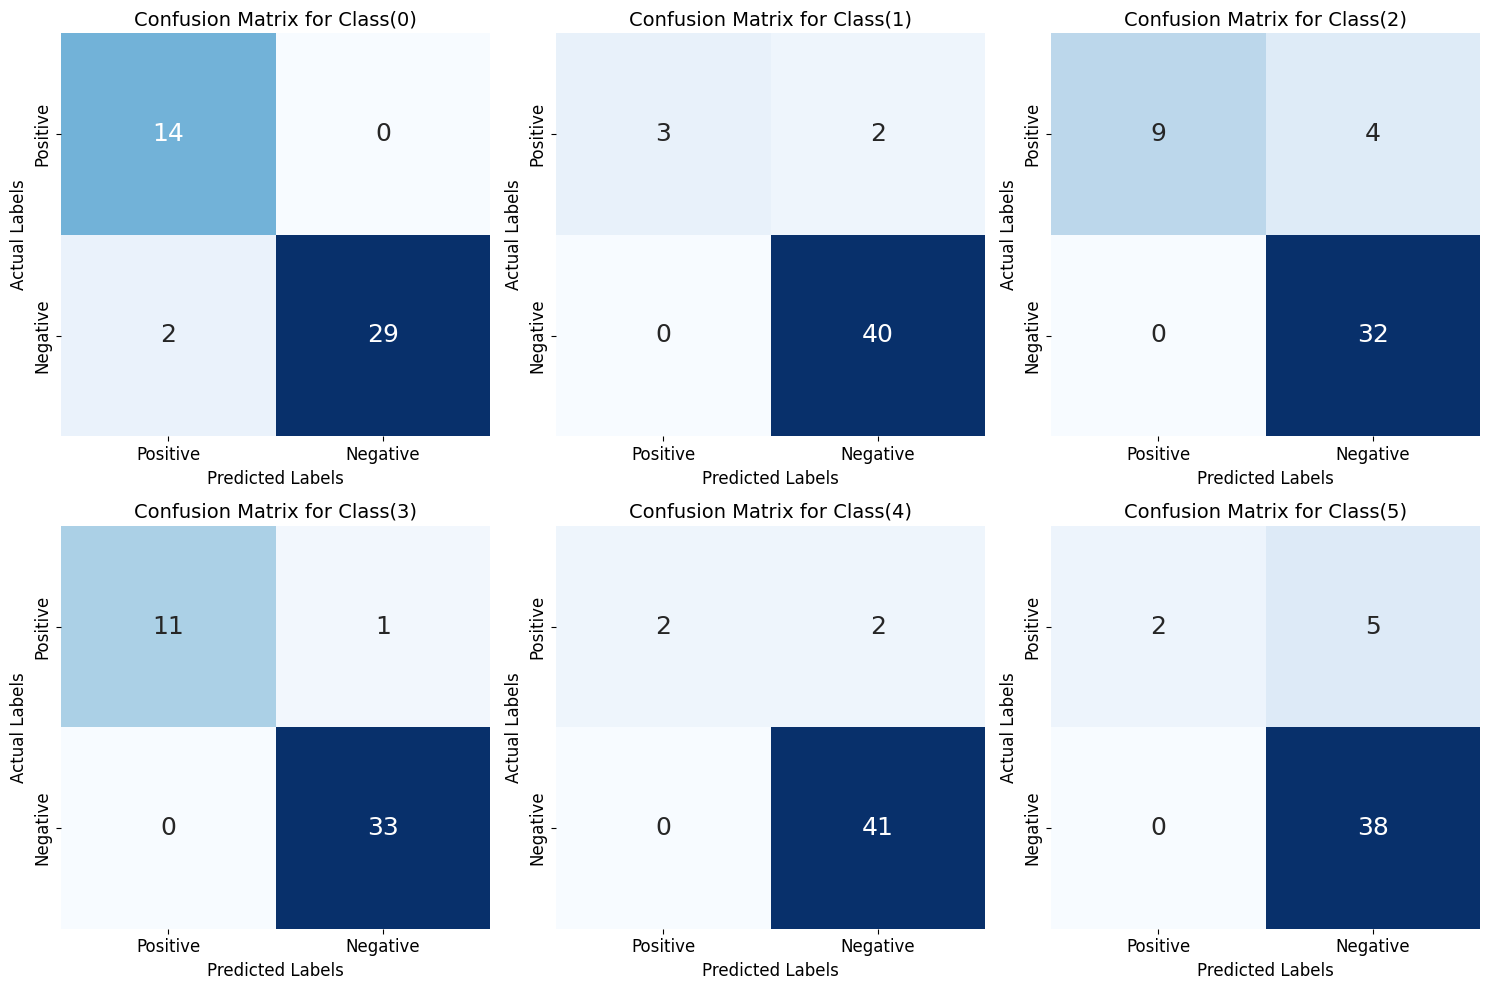

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

# Compute the confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot all confusion matrices in one frame
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the layout based on the number of classes

for i, ax in enumerate(axes.flat):
    if i < len(confusion_matrices):  # Ensure there are enough subplots for the number of classes
        # Get the confusion matrix
        cm = confusion_matrices[i]
        # Manually rearrange the values
        rearranged_cm = [[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]]
        sns.heatmap(rearranged_cm, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 18}, cbar=False)
        ax.set_title(f'Confusion Matrix for Class({i})', fontsize=14)
        ax.set_xticklabels(['Positive', 'Negative'], fontsize=12)
        ax.set_yticklabels(['Positive', 'Negative'], fontsize=12)
        ax.set_xlabel('Predicted Labels', fontsize=12)
        ax.set_ylabel('Actual Labels', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Concatenate all predictions and labels
all_predictions = torch.cat(all_predictions).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels.flatten(), all_predictions.flatten())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False, annot_kws={"fontsize": 12})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **All Models Accuracy comparison**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dictionary to store evaluation metrics for all models
evaluation_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'SVM': [88, 94, 96, 95],
    'LSTM': [94, 95, 78, 86],
    'DistilBERT': [98, 95, 98, 96]
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(evaluation_metrics)

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted, palette='viridis')

# Customize the plot
plt.title('Model Evaluation Metrics Comparison', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score (%)', fontsize=14)
plt.ylim(0, 100)  # Assuming the score ranges from 0 to 100
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Show the plot
plt.show()